In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from os import listdir
from collections import namedtuple

In [2]:
#has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

In [3]:
'''Load data'''

IMAGE_FOLDER = "../data/anime wallpapers"
image_png_names = listdir(IMAGE_FOLDER + "/png")
image_jpg_names = listdir(IMAGE_FOLDER + "/jpg")
image_png_paths = [IMAGE_FOLDER + '/png/' + name for name in image_png_names]
image_jpg_paths = [IMAGE_FOLDER + '/jpg/' + name for name in image_jpg_names]

In [4]:
def show_image(image):
        plt.matshow(image, cmap=plt.cm.gray)
        
def minibatch_image_generator(image_filenames, batch_size):
    epoch = 0 
    while 1:
        scrambled_images = np.random.permutation([misc.imread(img) for img in image_filenames])
        for batch_number in range(int(np.ceil(len(scrambled_images)/batch_size))):
            start_index = batch_number*batch_size
            end_index = min(len(scrambled_images),start_index+batch_size)
            yield epoch, scrambled_images[start_index:end_index]
        epoch = epoch + 1

In [5]:
gen = minibatch_image_generator(image_jpg_paths,1)


In [6]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride_input = [1, 2, 2, 1]):
  return tf.nn.conv2d(x, W, strides = stride_input, padding='SAME')

Dimensions = namedtuple('Dimensions', ['h', 'w'])

In [7]:
BATCH_SIZE = 1
SCALE = 2
INPUT_SIZE = Dimensions(135, 240)
OUTPUT_SIZE = Dimensions(INPUT_SIZE.h*SCALE, INPUT_SIZE.w*SCALE)

f_1 = 64
f_2 = 64
f_3 = 3 #For output image

n_1 = 20
n_2 = 1
n_3 = 8

s_1 = 1
s_2 = 1
s_3 = 1

In [8]:
small_train = tf.placeholder('float32', shape = [None, INPUT_SIZE.h, INPUT_SIZE.w, 3])
large_train = tf.placeholder('float32', shape = [None, OUTPUT_SIZE.h, OUTPUT_SIZE.w, 3])

small_train_hsv = tf.image.rgb_to_hsv(tf.div(small_train,255))
large_train_hsv = tf.image.rgb_to_hsv(tf.div(large_train,255))

small_train_flattened = tf.reshape(small_train_hsv,[-1, INPUT_SIZE.h*INPUT_SIZE.w*3])
large_train_flattened = tf.reshape(large_train_hsv,[-1, OUTPUT_SIZE.h*OUTPUT_SIZE.w*3])

w_conv1 = weight_variable([n_1,n_1,3,f_1])
b_conv1 = bias_variable([f_1])
h_conv1 = tf.nn.relu(conv2d(small_train_hsv, w_conv1, stride_input = [1, s_1, s_1, 1]) + b_conv1)

w_conv2 = weight_variable([n_2,n_2,f_1,f_2])
b_conv2 = bias_variable([f_2])
h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2, stride_input = [1, s_2, s_2, 1]) + b_conv2)

resized = tf.image.resize_bilinear(h_conv2, [OUTPUT_SIZE.h, OUTPUT_SIZE.w])

w_conv3 = weight_variable([n_3,n_3,f_2,f_3])
b_conv3 = bias_variable([f_3])
h_conv3 = conv2d(resized, w_conv3, stride_input = [1, s_3, s_3, 1]) + b_conv3



bounded = tf.minimum(tf.nn.relu(h_conv3),1)

prediction = tf.reshape(bounded,[-1,OUTPUT_SIZE.h*OUTPUT_SIZE.w*3])

MSE = tf.reduce_mean(tf.square(prediction - large_train_flattened))

pred = tf.cast(tf.mul(tf.image.hsv_to_rgb(bounded),255), dtype=tf.uint8)

optimizer = tf.train.AdamOptimizer().minimize(MSE)
t_size = tf.size(w_conv1)+tf.size(w_conv2)+tf.size(w_conv3)+tf.size(small_train)+tf.size(large_train)+tf.size(resized)

init = tf.initialize_all_variables()

In [9]:
image_gen = minibatch_image_generator(image_jpg_paths[0:1],BATCH_SIZE)

In [10]:
sess = tf.Session()
sess.run(init)

In [11]:
print("generating images") 
epoch,image_batch = next(image_gen)
in_image = np.array([scipy.misc.imresize(img,[INPUT_SIZE.h,INPUT_SIZE.w]) for img in image_batch])
out_image = np.array([scipy.misc.imresize(img,[OUTPUT_SIZE.h,OUTPUT_SIZE.w]) for img in image_batch])
print("generated images") 

generating images
generated images


In [ ]:
(size) = sess.run(t_size, feed_dict={small_train:in_image, large_train:out_image})
print("Tensors alone require: " + str(size*32/(2.0**32)) + " GB of vram")

In [19]:
for index in range(100):
    (_,mse) = sess.run([optimizer,MSE], feed_dict={small_train:in_image, large_train:out_image})
    if(index % 10 == 0):
        print('step = %-5d old mse = %-10f' % (index, mse*65025))
        
(sample) = sess.run(pred,feed_dict={small_train:in_image, large_train:out_image})

step = 0     old mse = 19896.504331
step = 10    old mse = 11484.413615
step = 20    old mse = 10475.262986
step = 30    old mse = 10202.861664
step = 40    old mse = 10019.433993
step = 50    old mse = 9839.091452
step = 60    old mse = 9651.597106
step = 70    old mse = 9495.490862
step = 80    old mse = 9369.929734
step = 90    old mse = 9256.676184


In [136]:
(sth) = sess.run(small_train_hsv,feed_dict={small_train:in_image, large_train:out_image})
sth[0][0][0:10]

array([[ 0.13333334,  0.70048314,  0.81176472],
       [ 0.1347032 ,  0.70531404,  0.81176472],
       [ 0.13669065,  0.66190481,  0.82352942],
       [ 0.13732395,  0.67942578,  0.81960785],
       [ 0.13909774,  0.62441319,  0.83529413],
       [ 0.14211886,  0.60280377,  0.8392157 ],
       [ 0.14304464,  0.58525348,  0.8509804 ],
       [ 0.14516129,  0.56621003,  0.85882354],
       [ 0.14845939,  0.53125   ,  0.87843138],
       [ 0.14814816,  0.48214287,  0.87843138]], dtype=float32)

In [ ]:
(sample) = sess.run(pred,feed_dict={small_train:in_image})

In [ ]:
plt.imshow(sample[0])

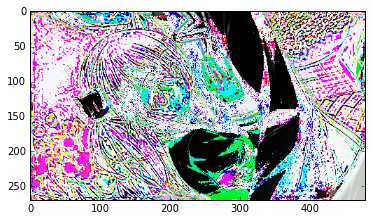

In [185]:
plt.imshow(sample[0]-out_image[0])

In [28]:
flat = np.reshape(out_image[0],[-1])
min(flat)

0

In [171]:
output_number = 13
rezoomed = misc.imresize(in_image[0],[OUTPUT_SIZE.h, OUTPUT_SIZE.w])
#output_number = output_number + 1
misc.imsave("../data/anime wallpapers/generated_output/"+str(output_number)+"_output.png", sample[0])
misc.imsave("../data/anime wallpapers/generated_output/"+str(output_number)+"_input.png", in_image[0])
misc.imsave("../data/anime wallpapers/generated_output/"+str(output_number)+"_origional.png", out_image[0])
print("Created images with number = "+str(output_number))

Created images with number = 13
